In [1]:
# ---------------------------------------------------------
# Code Cell 1: Category-Specific Data Preprocessing (Updated for Both Training and Test)
# ---------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 1. Load raw data
raw = pd.read_csv("filtered_data_lendingclub.csv")
raw.columns = raw.columns.str.strip()

# 2. Separate out meta & target, drop unwanted
meta = raw[["id", "loan_status"]].copy()
df   = raw.drop(columns=["id", "emp_title", "loan_status"], errors="ignore")

# 3. Stratified train/test split (keep meta in sync)
X_train, X_test, meta_train, meta_test = train_test_split(
    df, meta, test_size=0.2, random_state=42, stratify=meta["loan_status"]
)

# 4. Drop high‐NA cols learned on TRAIN only
thresh  = int(0.1 * len(X_train))   # need ≥10% non-null to keep
high_na = X_train.columns[X_train.isna().sum() > (len(X_train) - thresh)].tolist()
print("Dropping (train) cols >90% NaN:", high_na)
X_train = X_train.drop(columns=high_na)
X_test  = X_test.drop(columns=high_na, errors="ignore")

# 5a. Impute all remaining NaNs with -999
X_train = X_train.fillna(-999)
X_test  = X_test.fillna(-999)

# 5b. Drop low‑coverage categorical cols (top‑5 < 90%) learned on TRAIN
cat_cols   = X_train.select_dtypes(exclude=[np.number]).columns
low_covors = [
    c for c in cat_cols
    if X_train[c].astype(str).value_counts(normalize=True).nlargest(5).sum() * 100 < 90
]
print("Dropping (train) low‑coverage cats:", low_covors)
X_train = X_train.drop(columns=low_covors)
X_test  = X_test.drop(columns=low_covors, errors="ignore")

# 5c. One‑hot encode remaining non‑numeric columns on TRAIN, then align TEST
to_dummy = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
X_train  = pd.get_dummies(X_train, columns=to_dummy, drop_first=False)
X_test   = pd.get_dummies(X_test,  columns=to_dummy, drop_first=False)
X_test   = X_test.reindex(columns=X_train.columns, fill_value=0)

# 5d. Scale numeric features on TRAIN, apply to TEST
num_cols = X_train.select_dtypes(include=[np.number]).columns
scaler   = MinMaxScaler().fit(X_train[num_cols])
X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols]  = scaler.transform(X_test[num_cols])
# 5e. Re‑attach meta
train_proc = pd.concat([meta_train.reset_index(drop=True),
                        X_train.reset_index(drop=True)], axis=1)
test_proc  = pd.concat([meta_test.reset_index(drop=True),
                        X_test.reset_index(drop=True)],  axis=1)

# — Map your string labels to 0/1 on both splits —
mapping = {"Fully Paid": 1, "Charged Off": 0}
train_proc["loan_status"] = train_proc["loan_status"].map(mapping)
test_proc["loan_status"]  = test_proc["loan_status"].map(mapping)

train_proc.to_csv("train_processed.csv", index=False)

test_proc.to_csv("test_processed.csv",  index=False)

print("Saved train_processed.csv →", train_proc.shape)
print("Saved test_processed.csv  →", test_proc.shape)
# 4. Define your feature groups
group_features = {
    # 1. Core loan terms & borrower capacity
    "Loan_Terms": [
        "loan_amnt", "funded_amnt", "funded_amnt_inv",
        "int_rate", "installment", "dti", "annual_inc", "policy_code"
    ],

    # 2. Credit‐ and account‐level profile
    "Credit_Profile": [
        "delinq_2yrs", "fico_range_low", "fico_range_high",
        "inq_last_6mths", "mths_since_last_delinq", "mths_since_last_record",
        "open_acc", "pub_rec", "total_acc", "acc_now_delinq",
        "collections_12_mths_ex_med", "mths_since_last_major_derog",
        "pub_rec_bankruptcies", "tax_liens"
    ],

    # 3. Utilization & activity metrics
    "Utilization_and_Activity": [
        "revol_bal", "revol_util", "tot_cur_bal", "tot_hi_cred_lim",
        "total_bal_il", "il_util", "total_bal_ex_mort", "total_bc_limit",
        "total_il_high_credit_limit", "bc_open_to_buy", "bc_util",
        "total_rev_hi_lim", "avg_cur_bal", "num_rev_accts",
        "num_rev_tl_bal_gt_0", "pct_tl_nvr_dlq", "percent_bc_gt_75",
        "num_accts_ever_120_pd", "num_actv_bc_tl", "num_actv_rev_tl",
        "num_bc_sats", "num_bc_tl", "num_il_tl", "num_op_rev_tl",
        "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd",
        "num_tl_90g_dpd_24m", "num_tl_op_past_12m"
    ],

    

    # 5. One‐hot categorical flags
    "Categorical_Flags": [
        "term_ 36 months", "term_ 60 months",
        "grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G",
        "home_ownership_ANY", "home_ownership_MORTGAGE", "home_ownership_NONE",
        "home_ownership_OWN", "home_ownership_RENT",
        "verification_status_Not Verified", "verification_status_Source Verified",
        "verification_status_Verified",
        "pymnt_plan_n", "application_type_Individual", "application_type_Joint App",
        "hardship_flag_N", "disbursement_method_Cash", "disbursement_method_DirectPay",
        "debt_settlement_flag_N", "debt_settlement_flag_Y",
        # purpose dummies
        "purpose_car", "purpose_credit_card", "purpose_debt_consolidation",
        "purpose_home_improvement", "purpose_house", "purpose_major_purchase",
        "purpose_medical", "purpose_moving", "purpose_other",
        "purpose_renewable_energy", "purpose_small_business", "purpose_vacation",
        "purpose_wedding",
        # title dummies
        "title_Business", "title_Car financing", "title_Credit card refinancing",
        "title_Debt consolidation", "title_Green loan", "title_Home buying",
        "title_Home improvement", "title_Major purchase", "title_Medical expenses",
        "title_Moving and relocation", "title_Other", "title_Vacation",
        # listing & status
        "initial_list_status_f", "initial_list_status_w"
    ]
}



print("\nFeature‐group slices:")
for grp, feats in group_features.items():
    tr = train_proc[feats + ["loan_status"]]
    te = test_proc[feats + ["loan_status"]]
    print(f"{grp:25s} → train: {tr.shape}, test: {te.shape}")

/tmp/ipykernel_2728645/3351783234.py:10: DtypeWarning: Columns (118,129,130,131,134,135,136,139) have mixed types. Specify dtype option on import or set low_memory=False.
  raw = pd.read_csv("filtered_data_lendingclub.csv")


Dropping (train) cols >90% NaN: ['member_id', 'desc', 'next_pymnt_d', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']
Dropping (train) low‑coverage cats: ['sub_grade', 'e

In [3]:
# ---------------------------------------------------------
# Code Cell 3 (main): Base Model Training, Model Selection, and Meta-Model Training
# ---------------------------------------------------------
import os
import time
import joblib
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from joblib import Parallel, delayed
import logging


# 0. Configure logging globally
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)
logger = logging.getLogger()

# --- Configuration ---
NFOLDS    = 5
SEED      = 42
N_JOBS    = -1
MODEL_DIR = "enhanced_models"
os.makedirs(MODEL_DIR, exist_ok=True)

train_proc = pd.read_csv("train_processed.csv")
y_train_full = train_proc["loan_status"]

# 1) Define your same feature‐groups dict from Cell 2:
group_features = {
    # 1. Core loan terms & borrower capacity
    "Loan_Terms": [
        "loan_amnt", "funded_amnt", "funded_amnt_inv",
        "int_rate", "installment", "dti", "annual_inc", "policy_code"
    ],

    # 2. Credit‐ and account‐level profile
    "Credit_Profile": [
        "delinq_2yrs", "fico_range_low", "fico_range_high",
        "inq_last_6mths", "mths_since_last_delinq", "mths_since_last_record",
        "open_acc", "pub_rec", "total_acc", "acc_now_delinq",
        "collections_12_mths_ex_med", "mths_since_last_major_derog",
        "pub_rec_bankruptcies", "tax_liens"
    ],

    # 3. Utilization & activity metrics
    "Utilization_and_Activity": [
        "revol_bal", "revol_util", "tot_cur_bal", "tot_hi_cred_lim",
        "total_bal_il", "il_util", "total_bal_ex_mort", "total_bc_limit",
        "total_il_high_credit_limit", "bc_open_to_buy", "bc_util",
        "total_rev_hi_lim", "avg_cur_bal", "num_rev_accts",
        "num_rev_tl_bal_gt_0", "pct_tl_nvr_dlq", "percent_bc_gt_75",
        "num_accts_ever_120_pd", "num_actv_bc_tl", "num_actv_rev_tl",
        "num_bc_sats", "num_bc_tl", "num_il_tl", "num_op_rev_tl",
        "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd",
        "num_tl_90g_dpd_24m", "num_tl_op_past_12m"
    ],

    # 5. One‐hot categorical flags
    "Categorical_Flags": [
        "term_ 36 months", "term_ 60 months",
        "grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G",
        "home_ownership_ANY", "home_ownership_MORTGAGE", "home_ownership_NONE",
        "home_ownership_OWN", "home_ownership_RENT",
        "verification_status_Not Verified", "verification_status_Source Verified",
        "verification_status_Verified",
        "pymnt_plan_n", "application_type_Individual", "application_type_Joint App",
        "hardship_flag_N", "disbursement_method_Cash", "disbursement_method_DirectPay",
        "debt_settlement_flag_N", "debt_settlement_flag_Y",
        # purpose dummies
        "purpose_car", "purpose_credit_card", "purpose_debt_consolidation",
        "purpose_home_improvement", "purpose_house", "purpose_major_purchase",
        "purpose_medical", "purpose_moving", "purpose_other",
        "purpose_renewable_energy", "purpose_small_business", "purpose_vacation",
        "purpose_wedding",
        # title dummies
        "title_Business", "title_Car financing", "title_Credit card refinancing",
        "title_Debt consolidation", "title_Green loan", "title_Home buying",
        "title_Home improvement", "title_Major purchase", "title_Medical expenses",
        "title_Moving and relocation", "title_Other", "title_Vacation",
        # listing & status
        "initial_list_status_f", "initial_list_status_w"
    ]
}

# 2) Build per‑group DataFrames (dropping the loan_status column from features):
processed_group_dfs_train = {}
for grp, feats in group_features.items():
    df_grp = train_proc[ feats + ["loan_status"] ].copy()
    processed_group_dfs_train[grp] = df_grp
# --- Model Configurations ---
# (We keep the same grouping and model_configs as defined earlier.)


# --- Model Configurations (unchanged) ---
model_configs = {
    "XGBoost": {
        "model": xgb.XGBClassifier,
        "params": {
            "learning_rate": 0.05, "n_estimators": 200, "max_depth": 4,
            "subsample": 0.8, "colsample_bytree": 0.8,
            "objective": "binary:logistic", "n_jobs": N_JOBS,
            "random_state": SEED
        },
        "tune_params": {"max_depth": (3, 10), "learning_rate": (0.01,0.3), "n_estimators": (50,300)}
    },
    "GBDT": {
        "model": GradientBoostingClassifier,
        "params": {
            "learning_rate": 0.05, "n_estimators": 200, "max_depth": 4,
            "subsample": 0.8, "random_state": SEED
        },
        "tune_params": {"max_depth": (3, 10), "learning_rate": (0.01,0.3), "n_estimators": (50,300)}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier,
        "params": {"n_estimators":200, "learning_rate":0.05, "random_state":SEED},
        "tune_params": {"n_estimators": (50,300), "learning_rate": (0.01,1.0)}
    },
    "RandomForest": {
        "model": RandomForestClassifier,
        "params": {
            "n_estimators":200, "max_depth":12, "max_features":0.2,
            "min_samples_leaf":2, "n_jobs":N_JOBS, "random_state":SEED
        },
        "tune_params": {"n_estimators": (50,300), "max_depth": (3,20)}
    },
    "LightGBM": {
        "model": LGBMClassifier,
        "params": {
            "learning_rate":0.05, "n_estimators":200, "max_depth":6,
            "num_leaves":31, "subsample":0.8, "colsample_bytree":0.8,
            "n_jobs":N_JOBS, "random_state":SEED
        },
        "tune_params": {"learning_rate": (0.01,0.3), "n_estimators": (50,300), "num_leaves": (16,64)}
    }
}

# --- Start overall pipeline ---
start_total = time.time()
logger.info("🚀 Starting model stacking pipeline")

# --- Hyperparameter Tuning Phase ---
logger.info("🔄 Starting: Hyperparameter Tuning Phase")
start_tune = time.time()

def tune_hyperparameters(X, y, cfg):
    def objective(trial):
        params = {}
        for p, (low, high) in cfg["tune_params"].items():
            if isinstance(low, int):
                params[p] = trial.suggest_int(p, low, high)
            else:
                params[p] = trial.suggest_float(p, low, high)
        mdl = cfg["model"](**{**cfg["params"], **params})
        return np.mean(cross_val_score(mdl, X, y, cv=3, scoring="roc_auc"))
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=10)
    fn = os.path.join(MODEL_DIR, f"{cfg['model'].__name__}_tuning_study.pkl")
    joblib.dump(study, fn)
    logger.info(f"✅ Tuning study saved as: {fn}")
    return study.best_params

group_model_best = {}
for grp, df_grp in processed_group_dfs_train.items():
    Xg = df_grp.drop(columns=["loan_status"])
    yg = df_grp["loan_status"]
    group_model_best[grp] = {}
    for mname, cfg in model_configs.items():
        if "tune_params" in cfg:
            logger.info(f" 🔧 Tuning {mname} for {grp}")
            best = tune_hyperparameters(Xg, yg, cfg)
            group_model_best[grp][mname] = best
            cfg["params"].update(best)

end_tune = time.time()
logger.info("✅ Completed: Hyperparameter Tuning Phase in %.2f seconds", end_tune-start_tune)

# --- OOF Predictions Generation Phase ---
logger.info("🔄 Starting: Base Models OOF Training")
start_oof = time.time()

def train_fold(fold, tr_idx, val_idx, X_df, y_df, cfg, grp, mname):
    Xtr, Xval = X_df.iloc[tr_idx], X_df.iloc[val_idx]
    ytr, yval = y_df.iloc[tr_idx], y_df.iloc[val_idx]
    mdl = cfg["model"](**cfg["params"])
    mdl.fit(Xtr, ytr)
    path = os.path.join(MODEL_DIR, f"{grp}_{mname}_fold_{fold+1}.pkl")
    joblib.dump(mdl, path)
    logger.info(f" [fold {fold+1}] Saved model: {grp}_{mname}")
    return val_idx, mdl.predict_proba(Xval)[:,1]

def get_oof(mname, cfg, X_df, y_df, grp):
    oof = np.zeros(len(X_df))
    kf  = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)
    results = Parallel(n_jobs=N_JOBS)(
        delayed(train_fold)(i, ti, vi, X_df, y_df, cfg, grp, mname)
        for i,(ti,vi) in enumerate(kf.split(X_df))
    )
    for idxs, preds in results:
        oof[idxs] = preds
    auc = roc_auc_score(y_df, oof)
    logger.info(f" [{grp}] {mname} FINAL OOF AUC: {auc:.4f}")
    return oof.reshape(-1,1), auc

model_perf = {grp:{} for grp in processed_group_dfs_train}
oof_preds   = []
for grp, df_grp in processed_group_dfs_train.items():
    Xg = df_grp.drop(columns=["loan_status"])
    yg = df_grp["loan_status"]
    for mname, cfg in model_configs.items():
        preds, auc = get_oof(mname, cfg, Xg, yg, grp)
        oof_preds.append((f"{grp}_{mname}", preds))
        model_perf[grp][mname] = auc

end_oof = time.time()
logger.info("✅ Completed: Base Models OOF Training in %.2f seconds", end_oof-start_oof)

# --- Top-3 Selection ---
logger.info("🔄 Starting: Top Model Selection")
top_models = {}
for grp, scores in model_perf.items():
    top = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:3]
    top_models[grp] = top
    logger.info(f" [{grp}] ✅ Top 3 Models: {[m for m,_ in top]}")
logger.info("✅ Completed: Top Model Selection")

# --- Stack for Meta-Model ---
logger.info("🔄 Starting: Stacking top model predictions")
filtered = []
for grp, mods in top_models.items():
    for mname,_ in mods:
        for name,p in oof_preds:
            if name == f"{grp}_{mname}":
                filtered.append(p)
stacked_train = np.hstack(filtered)
logger.info("✅ Stacked train shape: %s", stacked_train.shape)

# --- Meta-Model Training ---
logger.info("🔄 Starting: Meta Model Training")
start_meta = time.time()

def tune_meta(X, y):
    def obj(trial):
        C = trial.suggest_float("C", 0.001, 1.0)
        mdl = LogisticRegression(penalty="l1", solver="liblinear", C=C, random_state=SEED)
        return np.mean(cross_val_score(mdl, X, y, cv=3, scoring="roc_auc"))
    st = optuna.create_study(direction="maximize")
    st.optimize(obj, n_trials=10)
    return st.best_params

best_meta = tune_meta(stacked_train, y_train_full)
meta = LogisticRegression(**best_meta, penalty="l1", solver="liblinear", random_state=SEED)
meta.fit(stacked_train, y_train_full)

mfn = os.path.join(MODEL_DIR, "stacking_meta_model.pkl")
joblib.dump(meta, mfn)
logger.info("✅ Meta-model saved: %s", mfn)

end_meta = time.time()
logger.info("✅ Completed: Meta Model Training in %.2f seconds", end_meta-start_meta)

# --- End of pipeline ---
end_total = time.time()
logger.info("🎯 Model stacking pipeline completed successfully in %.2f seconds", end_total-start_total)


2025-04-21 04:30:29,127 | INFO | 🚀 Starting model stacking pipeline
2025-04-21 04:30:29,128 | INFO | 🔄 Starting: Hyperparameter Tuning Phase
2025-04-21 04:30:29,133 | INFO |  🔧 Tuning XGBoost for Loan_Terms
[I 2025-04-21 04:30:29,134] A new study created in memory with name: no-name-ecf275b0-99c6-4ce0-b8f3-38914084ac85
[I 2025-04-21 04:32:13,189] Trial 0 finished with value: 0.6971398597158388 and parameters: {'max_depth': 3, 'learning_rate': 0.07252715434446645, 'n_estimators': 132}. Best is trial 0 with value: 0.6971398597158388.
[I 2025-04-21 04:34:19,359] Trial 1 finished with value: 0.7029330069535819 and parameters: {'max_depth': 6, 'learning_rate': 0.030600508163164522, 'n_estimators': 273}. Best is trial 1 with value: 0.7029330069535819.
[I 2025-04-21 04:37:04,911] Trial 2 finished with value: 0.6806590411968055 and parameters: {'max_depth': 9, 'learning_rate': 0.29349997503596753, 'n_estimators': 73}. Best is trial 1 with value: 0.7029330069535819.
[I 2025-04-21 04:40:57,507] 

[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.044855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-21 05:21:58,482] Trial 0 finished with value: 0.7009152523902351 and parameters: {'learning_rate': 0.10674719200712021, 'n_estimators': 223, 'num_leaves': 56}. Best is trial 0 with value: 0.7009152523902351.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:29:18,331] Trial 1 finished with value: 0.7027057301695604 and parameters: {'learning_rate': 0.04685862136119178, 'n_estimators': 299, 'num_leaves': 47}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-21 05:33:23,482] Trial 2 finished with value: 0.698304940713213 and parameters: {'learning_rate': 0.17413128323423951, 'n_estimators': 206, 'num_leaves': 56}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:33:25,944] Trial 3 finished with value: 0.6863433528103574 and parameters: {'learning_rate': 0.2857126823942139, 'n_estimators': 295, 'num_leaves': 38}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.3

[I 2025-04-21 05:33:26,748] Trial 4 finished with value: 0.7006900969270738 and parameters: {'learning_rate': 0.1720886523450258, 'n_estimators': 99, 'num_leaves': 21}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000735 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-21 05:33:29,534] Trial 5 finished with value: 0.7025419072914184 and parameters: {'learning_rate': 0.06082407192351822, 'n_estimators': 296, 'num_leaves': 57}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-04-21 05:33:31,497] Trial 6 finished with value: 0.7022054348281829 and parameters: {'learning_rate': 0.0949869021128025, 'n_estimators': 275, 'num_leaves': 24}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-21 05:33:56,598] Trial 7 finished with value: 0.6988964071268015 and parameters: {'learning_rate': 0.1544533663575865, 'n_estimators': 226, 'num_leaves': 47}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:34:09,119] Trial 8 finished with value: 0.698087686174155 and parameters: {'learning_rate': 0.028379048240409176, 'n_estimators': 76, 'num_leaves': 29}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1665
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

[I 2025-04-21 05:34:10,026] Trial 9 finished with value: 0.701727544958906 and parameters: {'learning_rate': 0.09983904529861665, 'n_estimators': 75, 'num_leaves': 39}. Best is trial 1 with value: 0.7027057301695604.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2025-04-21 05:34:10,109 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-21 05:34:10,118 | INFO |  🔧 Tuning XGBoost for Credit_Profile
[I 2025-04-21 05:34:10,119] A new study created in memory with name: no-name-c4112f77-28de-459e-a3b4-8577d654701e
[I 2025-04-21 05:36:02,472] Trial 0 finished with value: 0.6118024037356112 and parameters: {'max_depth': 6, 'learning_rate': 0.25222901851469737, 'n_estimators': 234}. Best is trial 0 with value: 0.6118024037356112.
[I 2025-04-21 05:36:03,598] Trial 1 finished with value: 0.6281205690966675 and parameters: {'max_depth': 6, 'learning_rate': 0.061319588485853435, 'n_estimators': 183}. Best is trial 1 with value: 0.6281205690966675.
[I 2025-04-21 05:36:04,306] Trial 2 finished with value: 0.6285890719504704 and parameters: {'max_depth': 3, 'learning_rate': 0.1534201467644069, 'n_estimators': 195}. Best is trial 2 with value: 0.6285890719504704.
[I 2025-04-21 05:36:04,931] Trial 3 finished with value: 0.

[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002623 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-04-21 05:57:10,962] Trial 0 finished with value: 0.6176935185958535 and parameters: {'learning_rate': 0.27712702087508645, 'n_estimators': 194, 'num_leaves': 39}. Best is trial 0 with value: 0.6176935185958535.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.187213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-04-21 05:57:41,176] Trial 1 finished with value: 0.6280141762002587 and parameters: {'learning_rate': 0.04627474413750774, 'n_estimators': 199, 'num_leaves': 41}. Best is trial 1 with value: 0.6280141762002587.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:59:31,578] Trial 2 finished with value: 0.6277716418155542 and parameters: {'learning_rate': 0.08930878789019264, 'n_estimators': 161, 'num_leaves': 17}. Best is trial 1 with value: 0.6280141762002587.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002002 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[I 2025-04-21 05:59:35,475] Trial 3 finished with value: 0.6283091176861332 and parameters: {'learning_rate': 0.011901904880007877, 'n_estimators': 293, 'num_leaves': 51}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:59:37,060] Trial 4 finished with value: 0.6183164047337685 and parameters: {'learning_rate': 0.27468778783331926, 'n_estimators': 218, 'num_leaves': 28}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-04-21 05:59:38,781] Trial 5 finished with value: 0.6195450041672346 and parameters: {'learning_rate': 0.2507156658944931, 'n_estimators': 286, 'num_leaves': 20}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 678
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

[I 2025-04-21 05:59:41,146] Trial 6 finished with value: 0.6174276631880777 and parameters: {'learning_rate': 0.20642361483708727, 'n_estimators': 285, 'num_leaves': 64}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:59:41,895] Trial 7 finished with value: 0.6252626219080303 and parameters: {'learning_rate': 0.2333312015394141, 'n_estimators': 78, 'num_leaves': 29}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:59:42,778] Trial 8 finished with value: 0.6280405058476982 and parameters: {'learning_rate': 0.11348166142069954, 'n_estimators': 66, 'num_leaves': 61}. Best is trial 3 with value: 0.6283091176861332.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 05:59:44,591] Trial 9 finished with value: 0.6150742440479507 and parameters: {'learning_rate': 0.2984964133874914, 'n_estimators': 219, 'num_leaves': 39}. Best is trial 3 with value: 0.6283091176861332.
2025-04-21 05:59:44,595 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-21 05:59:44,602 | INFO |  🔧 Tuning XGBoost for Utilization_and_Activity
[I 2025-04-21 05:59:44,603] A new study created in memory with name: no-name-4b6ca489-83d6-4f4a-8d64-905fbb0f7faa


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-21 06:00:49,209] Trial 0 finished with value: 0.6366677294759704 and parameters: {'max_depth': 9, 'learning_rate': 0.1128200655400084, 'n_estimators': 117}. Best is trial 0 with value: 0.6366677294759704.
[I 2025-04-21 06:00:50,723] Trial 1 finished with value: 0.6462590127183395 and parameters: {'max_depth': 9, 'learning_rate': 0.012396504333658269, 'n_estimators': 51}. Best is trial 1 with value: 0.6462590127183395.
[I 2025-04-21 06:00:51,393] Trial 2 finished with value: 0.6504619638352725 and parameters: {'max_depth': 4, 'learning_rate': 0.08322788701882147, 'n_estimators': 78}. Best is trial 2 with value: 0.6504619638352725.
[I 2025-04-21 06:00:52,953] Trial 3 finished with value: 0.6494438024955922 and parameters: {'max_depth': 5, 'learning_rate': 0.12457616761517096, 'n_estimators': 210}. Best is trial 2 with value: 0.6504619638352725.
[I 2025-04-21 06:00:53,666] Trial 4 finished with value: 0.6511113903461623 and parameters: {'max_depth': 3, 'learning_rate': 0.154350

[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.143006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

[I 2025-04-21 07:35:01,624] Trial 0 finished with value: 0.6521138056945511 and parameters: {'learning_rate': 0.06501991609449773, 'n_estimators': 191, 'num_leaves': 29}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-04-21 07:35:02,900] Trial 1 finished with value: 0.6435536598493912 and parameters: {'learning_rate': 0.2838772094713099, 'n_estimators': 137, 'num_leaves': 19}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001865 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-04-21 07:35:05,916] Trial 2 finished with value: 0.6439542578165304 and parameters: {'learning_rate': 0.13416227603241312, 'n_estimators': 280, 'num_leaves': 39}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-04-21 07:35:08,124] Trial 3 finished with value: 0.6496595196099894 and parameters: {'learning_rate': 0.10972030723587103, 'n_estimators': 263, 'num_leaves': 20}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001754 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-04-21 07:35:09,659] Trial 4 finished with value: 0.6433373689693164 and parameters: {'learning_rate': 0.215260830221333, 'n_estimators': 122, 'num_leaves': 40}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:35:17,163] Trial 5 finished with value: 0.6341761032266179 and parameters: {'learning_rate': 0.2851137845868574, 'n_estimators': 245, 'num_leaves': 24}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

[I 2025-04-21 07:35:20,069] Trial 6 finished with value: 0.6494907260881398 and parameters: {'learning_rate': 0.08712423040135411, 'n_estimators': 255, 'num_leaves': 40}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:35:23,024] Trial 7 finished with value: 0.6346097547050414 and parameters: {'learning_rate': 0.19920453305673855, 'n_estimators': 259, 'num_leaves': 49}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:35:25,047] Trial 8 finished with value: 0.6374941114439606 and parameters: {'learning_rate': 0.2498016064046282, 'n_estimators': 165, 'num_leaves': 52}. Best is trial 0 with value: 0.6521138056945511.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:35:26,931] Trial 9 finished with value: 0.643726817050924 and parameters: {'learning_rate': 0.1866972042846791, 'n_estimators': 170, 'num_leaves': 33}. Best is trial 0 with value: 0.6521138056945511.
2025-04-21 07:35:26,937 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-21 07:35:26,952 | INFO |  🔧 Tuning XGBoost for Categorical_Flags
[I 2025-04-21 07:35:26,953] A new study created in memory with name: no-name-5df69446-7869-4a4b-954e-7ec0303220c6


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-04-21 07:35:32,283] Trial 0 finished with value: 0.7152558643381667 and parameters: {'max_depth': 9, 'learning_rate': 0.1736928319891595, 'n_estimators': 146}. Best is trial 0 with value: 0.7152558643381667.
[I 2025-04-21 07:35:33,091] Trial 1 finished with value: 0.7255110227153301 and parameters: {'max_depth': 4, 'learning_rate': 0.12996944811465955, 'n_estimators': 155}. Best is trial 1 with value: 0.7255110227153301.
[I 2025-04-21 07:35:34,623] Trial 2 finished with value: 0.7252423071567803 and parameters: {'max_depth': 5, 'learning_rate': 0.08201890250658851, 'n_estimators': 206}. Best is trial 1 with value: 0.7255110227153301.
[I 2025-04-21 07:35:35,791] Trial 3 finished with value: 0.7258982518682138 and parameters: {'max_depth': 5, 'learning_rate': 0.04311772623351612, 'n_estimators': 183}. Best is trial 3 with value: 0.7258982518682138.
[I 2025-04-21 07:35:37,191] Trial 4 finished with value: 0.7182623154013731 and parameters: {'max_depth': 6, 'learning_rate': 0.27635

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002696 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-21 07:52:50,123] Trial 0 finished with value: 0.7241461096063215 and parameters: {'learning_rate': 0.2111955353539786, 'n_estimators': 86, 'num_leaves': 33}. Best is trial 0 with value: 0.7241461096063215.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:52:51,216] Trial 1 finished with value: 0.7252875137015883 and parameters: {'learning_rate': 0.09393203061736911, 'n_estimators': 92, 'num_leaves': 57}. Best is trial 1 with value: 0.7252875137015883.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:52:52,308] Trial 2 finished with value: 0.7247083838932342 and parameters: {'learning_rate': 0.15093185121197425, 'n_estimators': 166, 'num_leaves': 18}. Best is trial 1 with value: 0.7252875137015883.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.174464 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-21 07:52:54,896] Trial 3 finished with value: 0.7252624476081921 and parameters: {'learning_rate': 0.019563159292879637, 'n_estimators': 215, 'num_leaves': 50}. Best is trial 1 with value: 0.7252875137015883.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002135 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-21 07:52:55,956] Trial 4 finished with value: 0.7254718285435852 and parameters: {'learning_rate': 0.05848968490558573, 'n_estimators': 95, 'num_leaves': 40}. Best is trial 4 with value: 0.7254718285435852.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002114 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_

[I 2025-04-21 07:52:57,028] Trial 5 finished with value: 0.7232722131744587 and parameters: {'learning_rate': 0.24696958373379985, 'n_estimators': 169, 'num_leaves': 17}. Best is trial 4 with value: 0.7254718285435852.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ov

[I 2025-04-21 07:52:58,623] Trial 6 finished with value: 0.7238882964915376 and parameters: {'learning_rate': 0.12794351781373223, 'n_estimators': 208, 'num_leaves': 27}. Best is trial 4 with value: 0.7254718285435852.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 94717, number of negative: 25608
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 120325, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787176 -> initscore=1.307989
[LightGBM] [Info] Start training from score 1.307989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2025-04-21 07:52:59,881] Trial 7 finished with value: 0.7224867212917392 and parameters: {'learning_rate': 0.2353248841275168, 'n_estimators': 125, 'num_leaves': 42}. Best is trial 4 with value: 0.7254718285435852.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:53:01,337] Trial 8 finished with value: 0.7252007209859809 and parameters: {'learning_rate': 0.07744302648668842, 'n_estimators': 132, 'num_leaves': 64}. Best is trial 4 with value: 0.7254718285435852.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-21 07:53:02,574] Trial 9 finished with value: 0.7239705835062744 and parameters: {'learning_rate': 0.15847389067286627, 'n_estimators': 136, 'num_leaves': 32}. Best is trial 4 with value: 0.7254718285435852.
2025-04-21 07:53:02,578 | INFO | ✅ Tuning study saved as: enhanced_models/LGBMClassifier_tuning_study.pkl
2025-04-21 07:53:02,579 | INFO | ✅ Completed: Hyperparameter Tuning Phase in 12153.45 seconds
2025-04-21 07:53:02,579 | INFO | 🔄 Starting: Base Models OOF Training


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


2025-04-21 07:53:04,650 | INFO |  [Loan_Terms] XGBoost FINAL OOF AUC: 0.7018
2025-04-21 07:53:33,690 | INFO |  [Loan_Terms] GBDT FINAL OOF AUC: 0.7009
2025-04-21 07:53:52,782 | INFO |  [Loan_Terms] AdaBoost FINAL OOF AUC: 0.6935
2025-04-21 07:53:55,367 | INFO |  [Loan_Terms] RandomForest FINAL OOF AUC: 0.6932
/cvmfs/hpcsw.umd.edu/spack-software/2023.11.20/views/2023/linux-rhel8-zen2/gcc@11.3.0/python-3.10.10/mpi-nocuda/linux-rhel8-zen2/gcc/11.3.0/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
2025-04-21 08:08:52,395 | INFO |  [Loan_Terms] LightGBM FINAL OOF AUC: 0.7024
2025-04-21 08:08:55,650 | INFO |  [Credit_Profile] XGBoost FINAL OOF AUC: 0.6303
2025-04-21 08:09:14,209 | INFO |  [Credit_Profile] GBDT FINAL OOF AUC: 0.6294
2025-04-21 08:09:28,359 | INFO |  [Credit_Profile] AdaBoost FINAL OOF AUC: 

[LightGBM] [Info] Number of positive: 113649, number of negative: 30741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162297 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1666
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787097 -> initscore=1.307517
[LightGBM] [Info] Start training from score 1.307517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 113782, number of negative: 30

2025-04-21 08:25:15,887 | INFO |  [Credit_Profile] LightGBM FINAL OOF AUC: 0.6294
2025-04-21 08:25:20,439 | INFO |  [Utilization_and_Activity] XGBoost FINAL OOF AUC: 0.6538
2025-04-21 08:27:01,883 | INFO |  [Utilization_and_Activity] GBDT FINAL OOF AUC: 0.6520
2025-04-21 08:27:56,536 | INFO |  [Utilization_and_Activity] AdaBoost FINAL OOF AUC: 0.6470
2025-04-21 08:28:01,564 | INFO |  [Utilization_and_Activity] RandomForest FINAL OOF AUC: 0.6462


[LightGBM] [Info] Number of positive: 113683, number of negative: 30707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.965788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 683
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787333 -> initscore=1.308923
[LightGBM] [Info] Start training from score 1.308923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

2025-04-21 08:44:03,567 | INFO |  [Utilization_and_Activity] LightGBM FINAL OOF AUC: 0.6528
2025-04-21 08:44:08,185 | INFO |  [Categorical_Flags] XGBoost FINAL OOF AUC: 0.7256
2025-04-21 08:44:26,999 | INFO |  [Categorical_Flags] GBDT FINAL OOF AUC: 0.7254
2025-04-21 08:44:41,256 | INFO |  [Categorical_Flags] AdaBoost FINAL OOF AUC: 0.7247
2025-04-21 08:44:44,217 | INFO |  [Categorical_Flags] RandomForest FINAL OOF AUC: 0.7241


[LightGBM] [Info] Number of positive: 113649, number of negative: 30741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.760728 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4071
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787097 -> initscore=1.307517
[LightGBM] [Info] Start training from score 1.307517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 113683, number of negative: 30707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.666960 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=t

2025-04-21 08:59:52,170 | INFO |  [Categorical_Flags] LightGBM FINAL OOF AUC: 0.7252
2025-04-21 08:59:52,171 | INFO | ✅ Completed: Base Models OOF Training in 4009.59 seconds
2025-04-21 08:59:52,171 | INFO | 🔄 Starting: Top Model Selection
2025-04-21 08:59:52,172 | INFO |  [Loan_Terms] ✅ Top 3 Models: ['LightGBM', 'XGBoost', 'GBDT']
2025-04-21 08:59:52,173 | INFO |  [Credit_Profile] ✅ Top 3 Models: ['XGBoost', 'LightGBM', 'GBDT']
2025-04-21 08:59:52,174 | INFO |  [Utilization_and_Activity] ✅ Top 3 Models: ['XGBoost', 'LightGBM', 'GBDT']
2025-04-21 08:59:52,174 | INFO |  [Categorical_Flags] ✅ Top 3 Models: ['XGBoost', 'GBDT', 'LightGBM']
2025-04-21 08:59:52,174 | INFO | ✅ Completed: Top Model Selection
2025-04-21 08:59:52,175 | INFO | 🔄 Starting: Stacking top model predictions
2025-04-21 08:59:52,181 | INFO | ✅ Stacked train shape: (180488, 12)
2025-04-21 08:59:52,182 | INFO | 🔄 Starting: Meta Model Training
[I 2025-04-21 08:59:52,183] A new study created in memory with name: no-name-64

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113476, number of negative: 30914
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.373219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.785899 -> initscore=1.300382
[LightGBM] [Info] Start training from score 1.300382
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-04-21 09:00:24,079] Trial 0 finished with value: 0.7461736205734422 and parameters: {'C': 0.47437511923173764}. Best is trial 0 with value: 0.7461736205734422.
[I 2025-04-21 09:00:56,191] Trial 1 finished with value: 0.746165599765029 and parameters: {'C': 0.40995736229862095}. Best is trial 0 with value: 0.7461736205734422.
[I 2025-04-21 09:01:23,726] Trial 2 finished with value: 0.7461703788596482 and parameters: {'C': 0.30339645708331403}. Best is trial 0 with value: 0.7461736205734422.
[I 2025-04-21 09:01:54,937] Trial 3 finished with value: 0.7461431732156029 and parameters: {'C': 0.17312875945127018}. Best is trial 0 with value: 0.7461736205734422.
[I 2025-04-21 09:02:24,764] Trial 4 finished with value: 0.7461134338754714 and parameters: {'C': 0.10123046874027712}. Best is trial 0 with value: 0.7461736205734422.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113649, number of negative: 30741
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.215980 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787097 -> initscore=1.307517
[LightGBM] [Info] Start training from score 1.307517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

[I 2025-04-21 09:02:55,888] Trial 5 finished with value: 0.7461700408623978 and parameters: {'C': 0.4218649357743489}. Best is trial 0 with value: 0.7461736205734422.
[I 2025-04-21 09:03:30,484] Trial 6 finished with value: 0.7461790824409822 and parameters: {'C': 0.8803564070999631}. Best is trial 6 with value: 0.7461790824409822.
[I 2025-04-21 09:04:01,394] Trial 7 finished with value: 0.7461665897680717 and parameters: {'C': 0.3419503323469772}. Best is trial 6 with value: 0.7461790824409822.
[I 2025-04-21 09:04:30,283] Trial 8 finished with value: 0.7460209934711631 and parameters: {'C': 0.05309052524888864}. Best is trial 6 with value: 0.7461790824409822.
[I 2025-04-21 09:04:41,969] Trial 9 finished with value: 0.7431077008833737 and parameters: {'C': 0.007174629527326603}. Best is trial 6 with value: 0.7461790824409822.


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 113683, number of negative: 30707
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.161343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 96
[LightGBM] [Info] Number of data points in the train set: 144390, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.787333 -> initscore=1.308923
[LightGBM] [Info] Start training from score 1.308923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

2025-04-21 09:05:00,267 | INFO | ✅ Meta-model saved: enhanced_models/stacking_meta_model.pkl
2025-04-21 09:05:00,269 | INFO | ✅ Completed: Meta Model Training in 308.09 seconds
2025-04-21 09:05:00,269 | INFO | 🎯 Model stacking pipeline completed successfully in 16471.14 seconds


In [4]:
joblib.dump(top_models, os.path.join(MODEL_DIR, "top_models.pkl"))

['enhanced_models/top_models.pkl']

2025-04-21 09:05:00,641 | INFO | 🚀 Starting evaluation pipeline
2025-04-21 09:05:01,557 | INFO | ✅ Loaded test_processed.csv (45123 samples) in 0.92s
2025-04-21 09:05:01,569 | INFO | 🔄 Starting: Using processed test data (no NaNs) from preprocessing
2025-04-21 09:05:01,571 | INFO | 🔄 Starting: Generating base‑model predictions on test set
2025-04-21 09:05:06,350 | INFO | ✅ Completed: Generating base‑model predictions in 4.78s
2025-04-21 09:05:06,352 | INFO | 🔄 Starting: Meta‑model final predictions
2025-04-21 09:05:06,358 | INFO | ✅ Completed: Meta‑model final predictions in 0.00s
2025-04-21 09:05:06,364 | INFO | 🔄 Starting: Computing evaluation metrics & plots


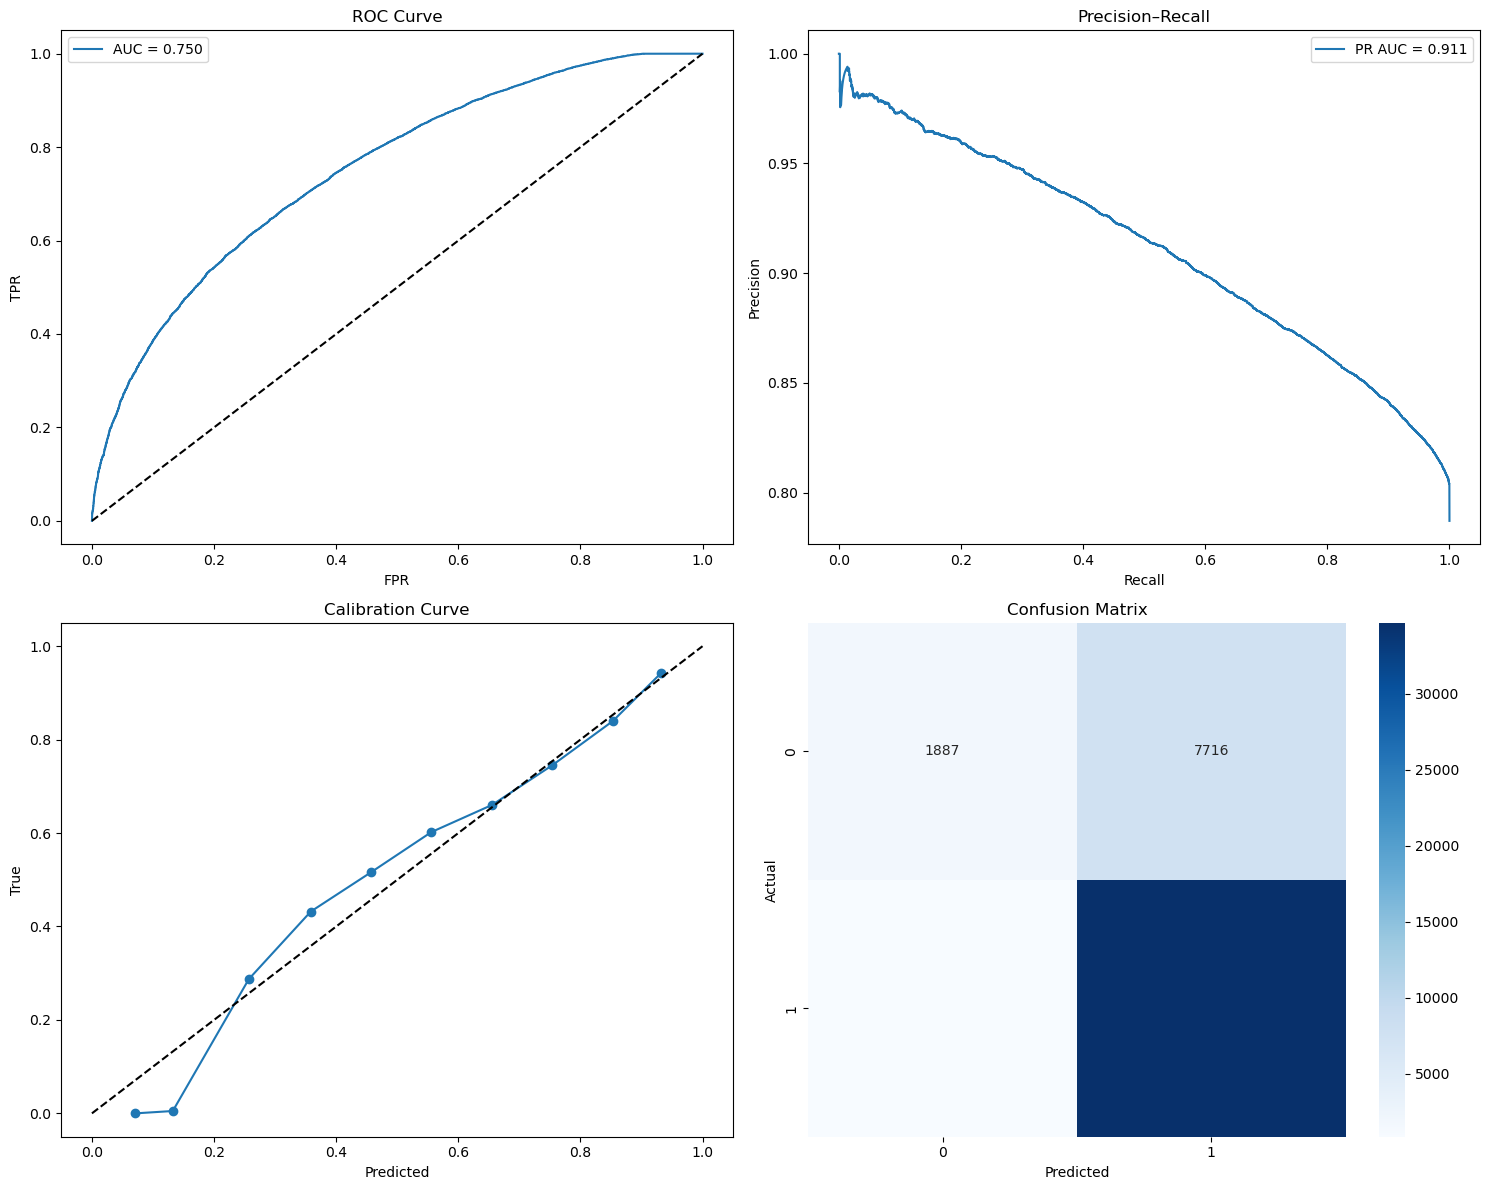

2025-04-21 09:05:07,403 | INFO | ✅ Completed: Evaluation in 1.04s
2025-04-21 09:05:07,414 | INFO | 📋 Classification Report:
              precision    recall  f1-score       support
0              0.685683  0.196501  0.305463   9603.000000
1              0.817894  0.975648  0.889833  35520.000000
accuracy       0.809831  0.809831  0.809831      0.809831
macro avg      0.751789  0.586074  0.597648  45123.000000
weighted avg   0.789757  0.809831  0.765469  45123.000000
2025-04-21 09:05:07,470 | INFO | 🎯 Final Evaluation Metrics:
2025-04-21 09:05:07,470 | INFO |     ROC AUC:           0.7503
2025-04-21 09:05:07,470 | INFO |     PR AUC:            0.9111
2025-04-21 09:05:07,471 | INFO |     Optimal threshold: 0.8005
2025-04-21 09:05:07,471 | INFO | 🎉 Evaluation pipeline completed successfully in 6.83s


In [5]:
# ---------------------------------------------------------
# Code Cell 4: Final Evaluation Using Only Top Models
# ---------------------------------------------------------
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from sklearn.metrics import (
    roc_auc_score, confusion_matrix,
    classification_report, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.calibration import calibration_curve

# 0. Configure logging globally
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
logger = logging.getLogger()

group_features = {
    # 1. Core loan terms & borrower capacity
    "Loan_Terms": [
        "loan_amnt", "funded_amnt", "funded_amnt_inv",
        "int_rate", "installment", "dti", "annual_inc", "policy_code"
    ],

    # 2. Credit‐ and account‐level profile
    "Credit_Profile": [
        "delinq_2yrs", "fico_range_low", "fico_range_high",
        "inq_last_6mths", "mths_since_last_delinq", "mths_since_last_record",
        "open_acc", "pub_rec", "total_acc", "acc_now_delinq",
        "collections_12_mths_ex_med", "mths_since_last_major_derog",
        "pub_rec_bankruptcies", "tax_liens"
    ],

    # 3. Utilization & activity metrics
    "Utilization_and_Activity": [
        "revol_bal", "revol_util", "tot_cur_bal", "tot_hi_cred_lim",
        "total_bal_il", "il_util", "total_bal_ex_mort", "total_bc_limit",
        "total_il_high_credit_limit", "bc_open_to_buy", "bc_util",
        "total_rev_hi_lim", "avg_cur_bal", "num_rev_accts",
        "num_rev_tl_bal_gt_0", "pct_tl_nvr_dlq", "percent_bc_gt_75",
        "num_accts_ever_120_pd", "num_actv_bc_tl", "num_actv_rev_tl",
        "num_bc_sats", "num_bc_tl", "num_il_tl", "num_op_rev_tl",
        "num_sats", "num_tl_120dpd_2m", "num_tl_30dpd",
        "num_tl_90g_dpd_24m", "num_tl_op_past_12m"
    ],


    # 5. One‐hot categorical flags
    "Categorical_Flags": [
        "term_ 36 months", "term_ 60 months",
        "grade_A", "grade_B", "grade_C", "grade_D", "grade_E", "grade_F", "grade_G",
        "home_ownership_ANY", "home_ownership_MORTGAGE", "home_ownership_NONE",
        "home_ownership_OWN", "home_ownership_RENT",
        "verification_status_Not Verified", "verification_status_Source Verified",
        "verification_status_Verified",
        "pymnt_plan_n", "application_type_Individual", "application_type_Joint App",
        "hardship_flag_N", "disbursement_method_Cash", "disbursement_method_DirectPay",
        "debt_settlement_flag_N", "debt_settlement_flag_Y",
        # purpose dummies
        "purpose_car", "purpose_credit_card", "purpose_debt_consolidation",
        "purpose_home_improvement", "purpose_house", "purpose_major_purchase",
        "purpose_medical", "purpose_moving", "purpose_other",
        "purpose_renewable_energy", "purpose_small_business", "purpose_vacation",
        "purpose_wedding",
        # title dummies
        "title_Business", "title_Car financing", "title_Credit card refinancing",
        "title_Debt consolidation", "title_Green loan", "title_Home buying",
        "title_Home improvement", "title_Major purchase", "title_Medical expenses",
        "title_Moving and relocation", "title_Other", "title_Vacation",
        # listing & status
        "initial_list_status_f", "initial_list_status_w"
    ]
}

# Configuration
MODEL_DIR = "enhanced_models"  # Must match Code Cell 3
NFOLDS    = 5
PLOT_DIR  = "evaluation_plots"
os.makedirs(PLOT_DIR, exist_ok=True)

def load_test_data():
    t0 = time.time()
    test_proc = pd.read_csv("test_processed.csv")
    # Extract X and y
    y_test = test_proc["loan_status"]
    # Drop meta‐columns (id) if present, leave only features + loan_status
    X_test = test_proc.drop(columns=["id", "loan_status"], errors="ignore")
    elapsed = time.time() - t0
    logger.info(f"✅ Loaded test_processed.csv ({len(X_test)} samples) in {elapsed:.2f}s")
    return X_test, y_test, test_proc

def generate_top_predictions(processed_group_dfs_test, top_models):
    logger.info("🔄 Starting: Generating base‑model predictions on test set")
    t0 = time.time()
    preds_list = []
    for grp, df_grp in processed_group_dfs_test.items():
        Xg = df_grp.drop(columns=["loan_status"], errors="ignore")
        for model_name, _ in top_models[grp]:
            fold_preds = []
            for f in range(1, NFOLDS+1):
                path = os.path.join(MODEL_DIR, f"{grp}_{model_name}_fold_{f}.pkl")
                model = joblib.load(path)
                fold_preds.append(model.predict_proba(Xg)[:,1])
            preds_list.append(np.mean(fold_preds, axis=0).reshape(-1,1))
    stacked = np.hstack(preds_list)
    logger.info(f"✅ Completed: Generating base‑model predictions in {time.time() - t0:.2f}s")
    return stacked

def generate_evaluation_plots(y_true, y_prob, metrics):
    plt.figure(figsize=(15, 12))
    # ROC
    plt.subplot(2,2,1)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.3f}')
    plt.plot([0,1],[0,1],'k--')
    plt.title("ROC Curve"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend()
    # Precision-Recall
    plt.subplot(2,2,2)
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.plot(recall, precision, label=f'PR AUC = {metrics["pr_auc"]:.3f}')
    plt.title("Precision–Recall"); plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()
    # Calibration
    plt.subplot(2,2,3)
    prob_true, prob_pred = calibration_curve(y_true, y_prob, n_bins=10)
    plt.plot(prob_pred, prob_true, 'o-')
    plt.plot([0,1],[0,1],'k--')
    plt.title("Calibration Curve"); plt.xlabel("Predicted"); plt.ylabel("True")
    # Confusion
    plt.subplot(2,2,4)
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout()
    plt.savefig(os.path.join(PLOT_DIR, "full_evaluation.png"))
    plt.show()
    plt.close()

def comprehensive_evaluation(y_true, y_prob):
    logger.info("🔄 Starting: Computing evaluation metrics & plots")
    t0 = time.time()
    y_pred = (y_prob >= 0.5).astype(int)
    metrics = {
        'confusion_matrix':    confusion_matrix(y_true, y_pred),
        'classification_report': classification_report(y_true, y_pred, output_dict=True),
        'roc_auc':             roc_auc_score(y_true, y_prob),
        'pr_auc':              average_precision_score(y_true, y_prob),
    }
    fpr, tpr, thr = roc_curve(y_true, y_prob)
    metrics['optimal_threshold'] = thr[np.argmax(tpr - fpr)]
    generate_evaluation_plots(y_true, y_prob, metrics)
    logger.info(f"✅ Completed: Evaluation in {time.time() - t0:.2f}s")
    return metrics

def main():
    logger.info("🚀 Starting evaluation pipeline")
    t_pipeline = time.time()

    # 1) Load from memory
    X_test, y_test, test_proc = load_test_data()
    
    # Rebuild the test‐group DataFrames
    processed_group_dfs_test = {
       grp: test_proc[feats + ["loan_status"]].copy()
       for grp, feats in group_features.items()
    }
    logger.info("🔄 Starting: Using processed test data (no NaNs) from preprocessing")
    
    top_models = joblib.load(os.path.join(MODEL_DIR, "top_models.pkl"))
    # 3) Base-model stacking
    stacked = generate_top_predictions(processed_group_dfs_test, top_models)

    # 4) Meta-model final predictions
    logger.info("🔄 Starting: Meta‑model final predictions")
    t0 = time.time()
    meta = joblib.load(os.path.join(MODEL_DIR, "stacking_meta_model.pkl"))
    final_probs = meta.predict_proba(stacked)[:,1]
    logger.info(f"✅ Completed: Meta‑model final predictions in {time.time() - t0:.2f}s")

    # 5) Compute metrics & plots
    metrics = comprehensive_evaluation(y_test, final_probs)

    report_df = pd.DataFrame(metrics['classification_report']).transpose()
    logger.info("📋 Classification Report:\n" + report_df.to_string())
    # 6) Save & log final results
    results_df = pd.DataFrame({
        'true_label':      y_test,
        'predicted_prob':  final_probs,
        'predicted_label': (final_probs >= metrics['optimal_threshold']).astype(int)
    })
    results_df.to_csv(os.path.join(PLOT_DIR, "final_predictions.csv"), index=False)

    logger.info("🎯 Final Evaluation Metrics:")
    logger.info(f"    ROC AUC:           {metrics['roc_auc']:.4f}")
    logger.info(f"    PR AUC:            {metrics['pr_auc']:.4f}")
    logger.info(f"    Optimal threshold: {metrics['optimal_threshold']:.4f}")
    logger.info(f"🎉 Evaluation pipeline completed successfully in {time.time() - t_pipeline:.2f}s")

if __name__ == "__main__":
    main()


In [41]:
counts = df_count['class'].value_counts()
print(counts)

0    6756
1     271
Name: class, dtype: int64


In [42]:
import pandas as pd
from scipy.io import arff

# Load the ARFF file
data1, meta1 = arff.loadarff('1year.arff')
df_count = pd.DataFrame(data1)

# If values in the 'class' column are byte strings, decode them
if df_count['class'].dtype == object:
    df_count['class'] = df_count['class'].apply(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Count the occurrences in the 'class' column
counts = df_count['class'].value_counts()

# Convert counts to percentages
percentages = (counts / counts.sum()) * 100

# Optionally, round the percentages to two decimal places
percentages = percentages.round(2)

# Print the results
print(percentages)


0    96.14
1     3.86
Name: class, dtype: float64


In [43]:
df_count.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,...,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,...,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,...,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,...,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,...,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,...,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0
